# *lsforce* example script: 2016 Lamplugh rock avalanche
---

This example notebook uses *lsforce* to invert for the force-time function of the 28 June 2016 Lamplugh rock avalanche in Glacier Bay National Park, Alaska (Bessette-Kirton et al., 2018; Dufresne et al., 2019). The notebook walks through data collection and creation of all three major *lsforce* objects: `LSData`, `LSForce`, and `LSTrajectory`. The latter two objects are created twice, once each for the "full" parameterization method (`method='full'`) and the "triangle" parameterization method (`method='triangle'`).

**References**

<p>
<div style="text-indent:-36px; padding-left:36px;">
<p>
Bessette-Kirton, E. K., Coe, J. A., & Zhou, W. (2018). Using stereo satellite imagery to account for ablation, entrainment, and compaction in volume calculations for rock avalanches on glaciers: application to the 2016 Lamplugh rock avalanche in Glacier Bay National Park, Alaska. <em>Journal of Geophysical Research: Earth Surface, 123</em>(4), 622–641. <a href="https://doi.org/10.1002/2017JF004512">https://doi.org/10.1002/2017JF004512</a>
</p>
<p>
Dufresne, A., Wolken, G. J., Hibert, C., Bessette-Kirton, E. K., Coe, J. A., Geertsema, M., & Ekström, G. (2019). The 2016 Lamplugh rock avalanche, Alaska: deposit structures and emplacement dynamics. <em>Landslides, 16</em>(12), 2301–2319. <a href="https://doi.org/10.1007/s10346-019-01225-4">https://doi.org/10.1007/s10346-019-01225-4</a>
</p>
</div>

### Import necessary modules

In [1]:
from pathlib import Path

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth

from lsforce import LSData, LSForce, LSTrajectory

# Ignore benign Matplotlib backend warning due to fig.show()
import warnings
warnings.filterwarnings(action='ignore', message='Matplotlib is currently using module')

### Define some constants, set up folder structure

In [2]:
PERIOD_RANGE = (10, 200)  # [s] Bandpass filter corners

LS_LAT, LS_LON = (58.7371, -136.8943)  # Guesstimate from Google Earth + lamplugh.tif
ORIGIN_TIME = UTCDateTime(2016, 6, 28, 16, 21, 3)

STARTTIME = ORIGIN_TIME - 150
ENDTIME = UTCDateTime(2016, 6, 28, 16, 26, 6) + 150

# Set up folder structure
main_folder = Path.cwd() / 'lamplugh'
if not main_folder.exists():
    main_folder.mkdir()

### Gather inversion waveforms

AK.JIS..BHE -> AK.JIS..BHE
{'azimuth': 90.0, 'dip': 0.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 1 / 30150 (0.00332%)
Max absolute difference: 2.2737367544323206e-13
Max relative difference: 6.816769371198461e-14
 x: array([  974.,   980.,  1016., ...,   906.,   935.,  1017.])
 y: array([ 974,  980, 1016, ...,  906,  935, 1017], dtype=int32)

AK.JIS..BHZ -> AK.JIS..BHZ
{'azimuth': 0.0, 'dip': -90.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 73 / 30150 (0.242%)
Max absolute difference: 2.2737367544323206e-13
Max relative difference: 5.5067062021407764e-14
 x: array([-148., -131., -144., ...,  -20.,  -82., -103.])
 y: array([-148, -131, -144, ...,  -20,  -82, -103], dtype=int32)

AK.PNL..BHE -> AK.PNL..BHE
{'azimuth': 90.0, 'dip': 0.0}
Not equal to tolerance rtol=1e-07, atol=0
Mismatched elements: 11 / 30150 (0.0365%)
Max absolute difference: 2.2737367544323206e-13
Max relative difference: 3.164135620181696e-14
 x: array([-1169., -1160., -1165.

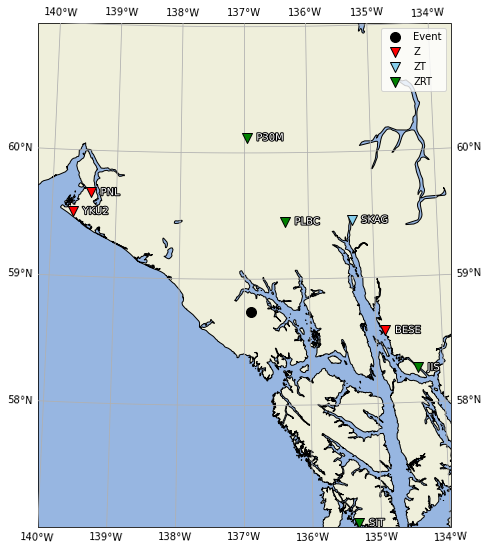

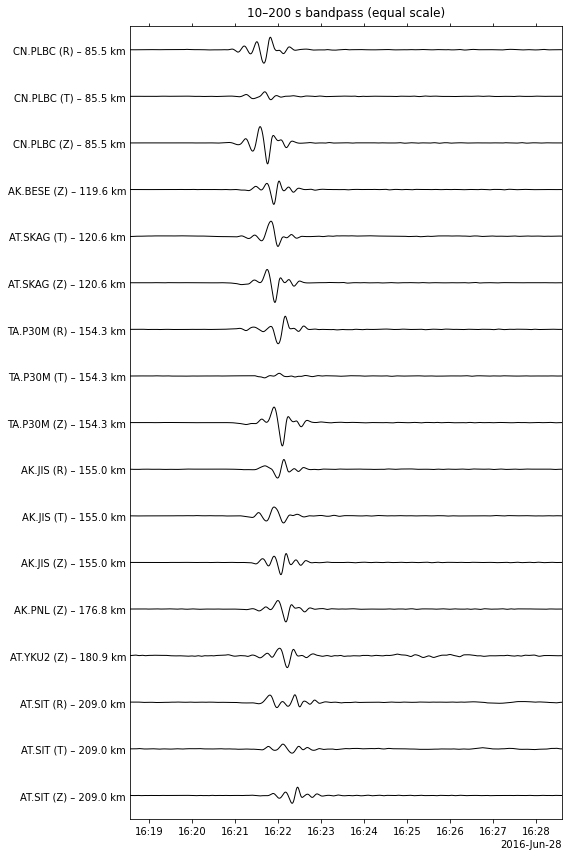

In [3]:
data_filename = main_folder / 'data.pkl'

# Download data if it doesn't exist as a file
if not data_filename.exists():

    client = Client('IRIS')
    waveform_kwargs = dict(
        location='', starttime=STARTTIME, endtime=ENDTIME, attach_response=True
    )

    # Gather waveforms
    NETWORKS = ('AK', 'AT', 'CN', 'TA')
    STATIONS = ('SKAG', 'BESE', 'P30M', 'JIS', 'PNL', 'YKU2', 'PLBC', 'SIT')
    st = client.get_waveforms(
        network=','.join(NETWORKS),
        station=','.join(STATIONS),
        channel='BH?,HH?',
        **waveform_kwargs,
    )

    # Grab coordinates
    inv = client.get_stations(
        network=','.join(NETWORKS),
        starttime=STARTTIME,
        endtime=ENDTIME,
        level='channel',
    )

    # Assign coordinates to Traces
    for tr in st:
        coords = inv.get_coordinates(tr.id, datetime=STARTTIME)
        tr.stats.latitude = coords['latitude']
        tr.stats.longitude = coords['longitude']

    st.write(str(data_filename), format='PICKLE')

# Use file if it exists, for speed
else:
    st = read(str(data_filename), format='PICKLE')

# Create LSData object
data = LSData(st, source_lat=LS_LAT, source_lon=LS_LON)

# Remove some noisy horizontals
for station in 'BESE', 'PNL', 'YKU2':
    for tr in data.st_proc.select(station=station, component='[RT]'):
        data.st_proc.remove(tr)
for tr in data.st_proc.select(station='SKAG', component='R'):
    data.st_proc.remove(tr)

# Create plots
data.plot_stations(label_stations=True, gshhs_scale='h');
data.plot_data(period_range=PERIOD_RANGE);

### Gather reference waveform

In [4]:
SEISMIC_VELO = 2.5  # [km/s] For travel time removal

KM_PER_M = 1 / 1000  # [km/m]

client = Client('IRIS')

# Gather a single trace
tr_hf = client.get_waveforms(
    network='CN',
    station='PLBC',
    location='',
    channel='HHZ',
    starttime=STARTTIME,
    endtime=ENDTIME,
    attach_response=True,
)[0]

# Processing
tr_hf.remove_response()
tr_hf.detrend('demean')
tr_hf.taper(max_percentage=0.05)
tr_hf.filter('bandpass', freqmin=0.5, freqmax=5)

# Add "distance" to tr.stats
ref_inv = client.get_stations(
    network=tr_hf.stats.network,
    station=tr_hf.stats.station,
    starttime=STARTTIME,
    endtime=ENDTIME,
    level='channel',
)
coords = ref_inv.get_coordinates(tr_hf.id, datetime=STARTTIME)
tr_hf.stats.latitude = coords['latitude']
tr_hf.stats.longitude = coords['longitude']
dist = gps2dist_azimuth(LS_LAT, LS_LON, tr_hf.stats.latitude, tr_hf.stats.longitude)[0]  # [m]
tr_hf.stats.distance = dist * KM_PER_M  # [km]

# Approximate correction for travel time
hf_shift = tr_hf.stats.distance / SEISMIC_VELO

### Setup both full and triangle parameterization methods

In [5]:
INIT_KWARGS = dict(data=data, data_sampling_rate=1, main_folder=main_folder)

force_full = LSForce(**INIT_KWARGS)
force_triangle = LSForce(method='triangle', **INIT_KWARGS)

SETUP_KWARGS = dict(
    period_range=PERIOD_RANGE,
    zerophase=True,
    syngine_model='iasp91_2s',
    weights='prenoise',
    noise_window_dur=150,
)

force_full.setup(**SETUP_KWARGS)
force_triangle.setup(**SETUP_KWARGS, triangle_half_width=5)

Getting Green's functions...
Downloaded BESE (1/8)
Downloaded JIS (2/8)
Downloaded P30M (3/8)
Downloaded PLBC (4/8)
Downloaded PNL (5/8)
Downloaded SIT (6/8)
Downloaded SKAG (7/8)
Downloaded YKU2 (8/8)
Getting Green's functions...
Downloaded BESE (1/8)
Downloaded JIS (2/8)
Downloaded P30M (3/8)
Downloaded PLBC (4/8)
Downloaded PNL (5/8)
Downloaded SIT (6/8)
Downloaded SKAG (7/8)
Downloaded YKU2 (8/8)


### Invert both

In [6]:
INVERT_KWARGS = dict(
    zero_time=146,
    impose_zero_start=True,
    add_to_zero=True,
    jackknife=True,
    num_iter=20,
    frac_delete=0.25,
    tikhonov_ratios=(0, 0, 1),
    zero_scaler=10,
)

force_full.invert(alpha=2.8e-16, **INVERT_KWARGS)
force_triangle.invert(alpha=2.8e-17, **INVERT_KWARGS)

Variance reduction = 83.249144 percent
Jackknife VR stats: max 86, min 80, median 84
Variance reduction = 83.020663 percent
Jackknife VR stats: max 85, min 80, median 83


### Plot inversion results

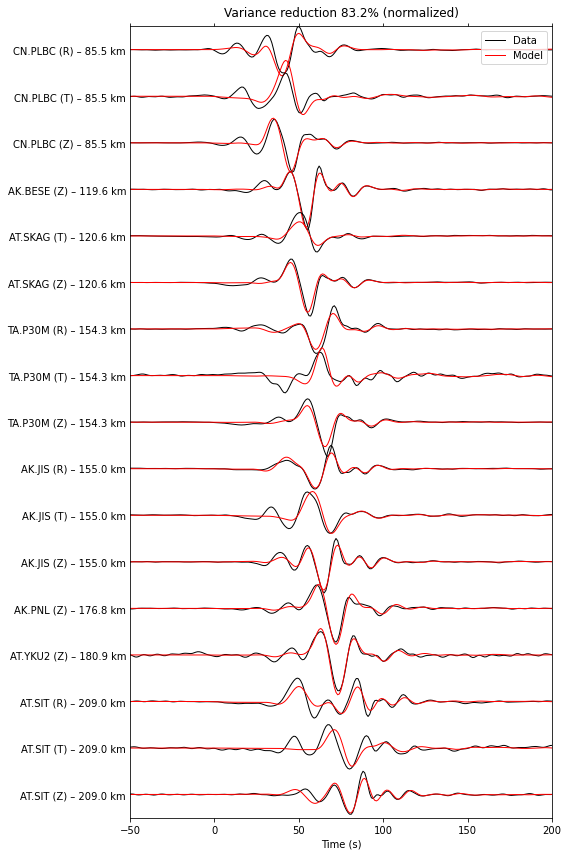

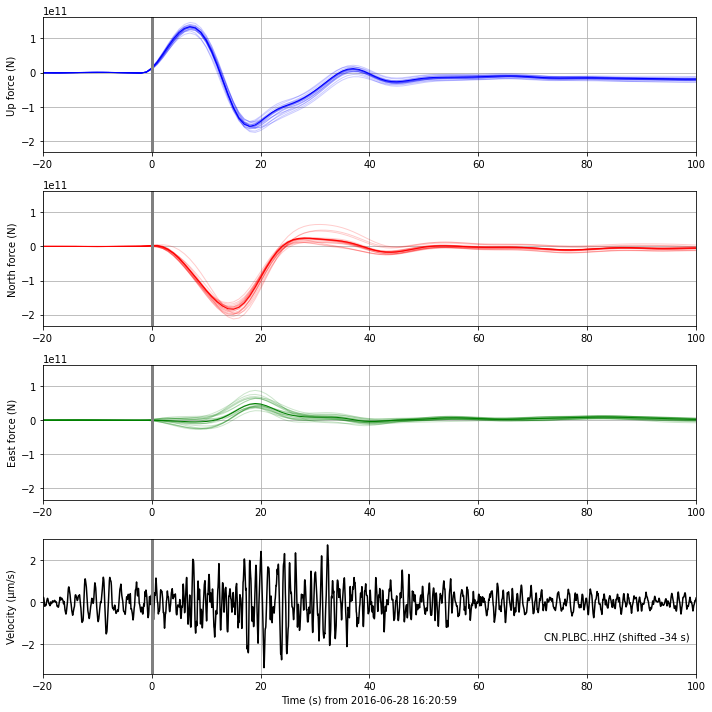

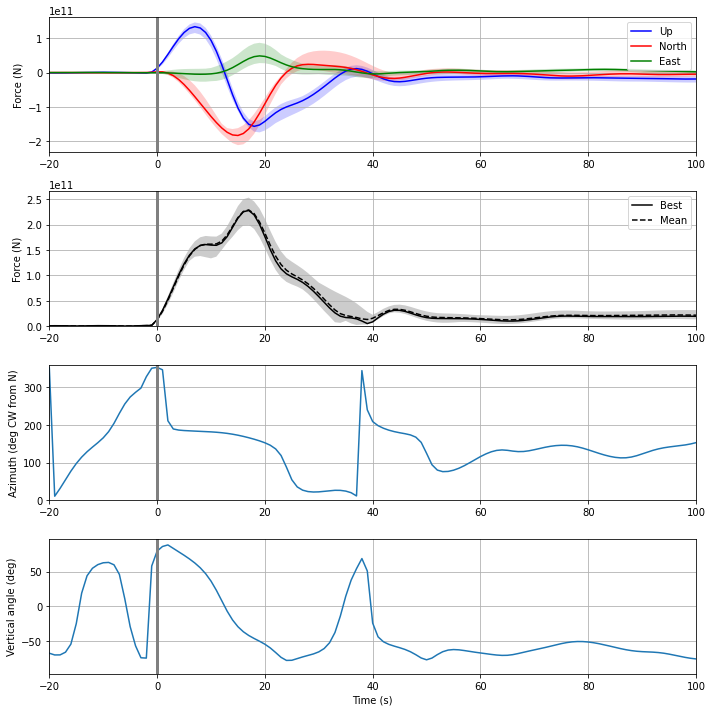

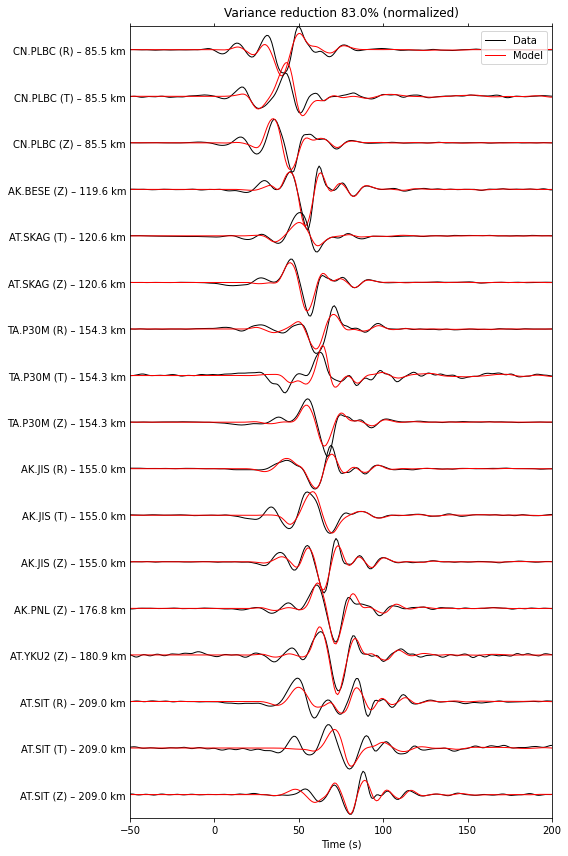

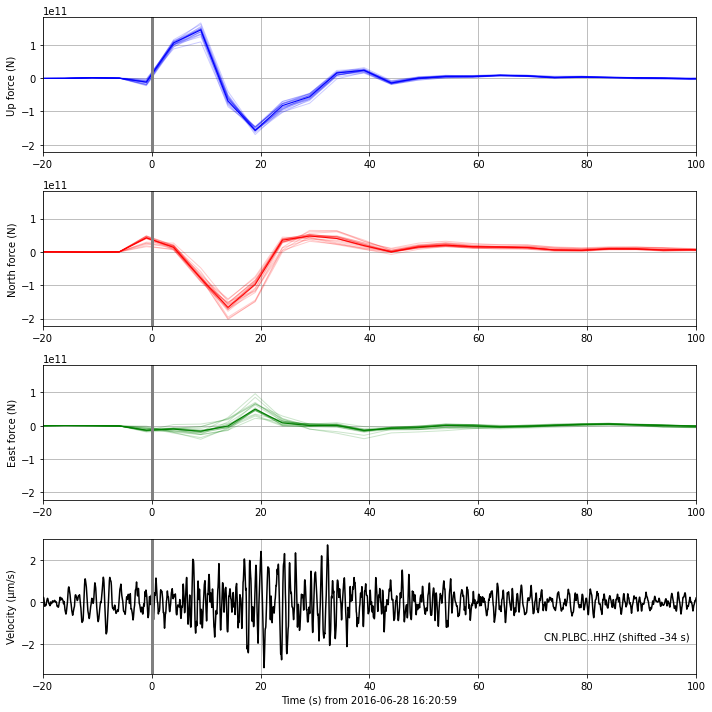

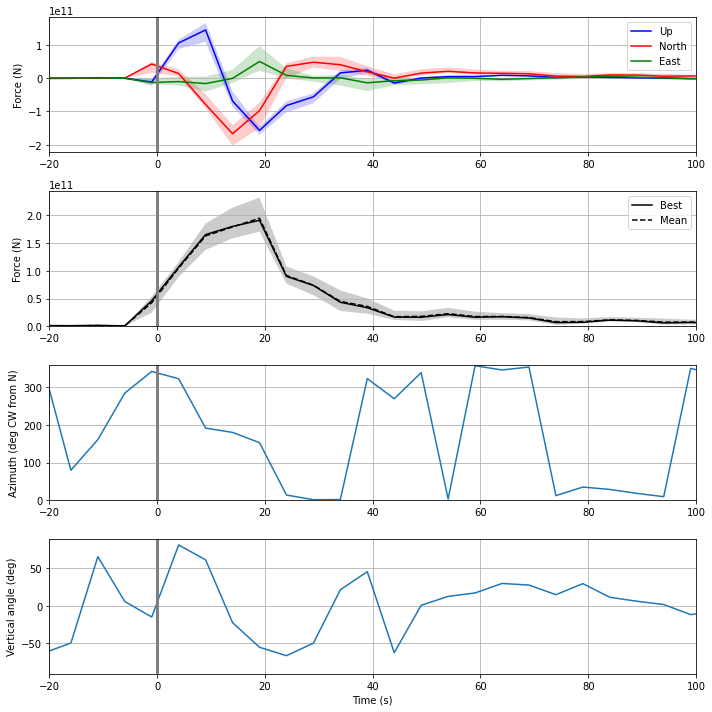

In [7]:
XLIM = (-20, 100)  # [s] x-axis (time) limits for plots

for force in force_full, force_triangle:
    force.plot_fits(xlim=(-50, 200), equal_scale=False);
    force.plot_forces(highf_tr=tr_hf, hfshift=hf_shift, jackshowall=True, xlim=XLIM);
    force.plot_angle_magnitude(xlim=XLIM);

### Compute trajectories

In [8]:
L = 4  # [km] Estimate of horizontal COM runout length
DURATION = 100  # [s] Duration to use for trajectory integration

TRAJECTORY_KWARGS = dict(target_length=L, duration=DURATION, detrend_velocity=DURATION)

trajectory_full = LSTrajectory(force_full, **TRAJECTORY_KWARGS)
trajectory_triangle = LSTrajectory(force_triangle, **TRAJECTORY_KWARGS)

### Plot trajectories

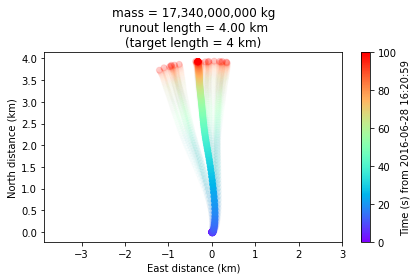

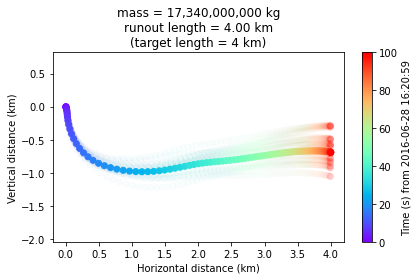

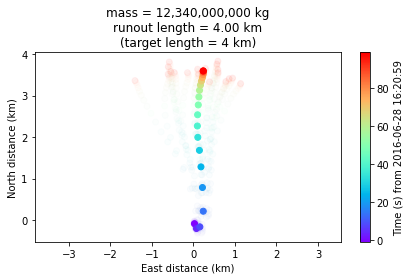

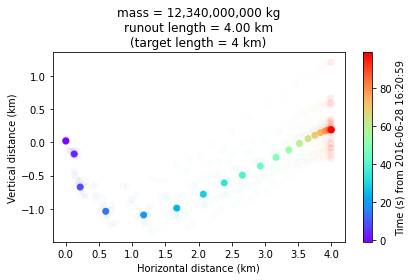

In [9]:
for trajectory in trajectory_full, trajectory_triangle:
    trajectory.plot_trajectory(plot_jackknife=True);  # Horizontal trajectory
    trajectory.plot_trajectory(plot_jackknife=True, elevation_profile=True);  # Vertical trajectory